In [13]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.compose import ColumnTransformer
from utils import run_kfold, run_kfold_eval, run_kfold_trainonly, feature_selection, calculate_metric
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import time
import joblib
from pathlib import Path
import shap
import numpy as np

In [2]:
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../OUTPUT/svm'
OOF_PREDICTIONS_FILE = '../output/oof_predictions.xlsx'
OUTPUT_FILE = OUTPUT_PATH + '/model.pkl'

TRAINING_OUTPUT_FILE = '../output/train_predictions.xlsx'
TEST_OUTPUT_FILE = '../output/test_predictions.xlsx'
SHEET_NAME = "svm"

# Create output directory if it doesn't exist
output_dir = Path(OUTPUT_PATH)
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [4]:
print("Train feature shape: ",train_features.shape)
print("Train label shape: ",train_labels.shape)
print("Test feature shape: ",test_features.shape)
print("Train label shape: ",test_labels.shape)

Train feature shape:  (1293, 317)
Train label shape:  (1293, 1)
Test feature shape:  (432, 317)
Train label shape:  (432, 1)


In [5]:
train_features.head()

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False


In [6]:
train_labels.head()

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458


In [7]:
feature_list = train_features.columns
category_feature_key = ['currency', 'seniorioty_adj', 'domicile_country',	'exchange_country',	'Industry_sector',	'Industry_group',	'Industry_subgroup', 'event_type',
                 'event_type_subcategory_sum', 'defaulted_in_last_6_months']
category_features = [i for i in feature_list if any(sub in i for sub in category_feature_key)]
non_category_features = [i for i in feature_list if i not in category_features]

print(len(category_features))
print(len(non_category_features))

163
154


In [8]:
# Normalize the data
# Prepare the ColumnTransformer
scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), non_category_features)
    ],
    remainder='passthrough'  # Leave categorical features untouched
)

In [25]:
def objective(trial):
    # train_x, valid_x, train_y, valid_y = train_test_split(train_feature_df, train_label_df, test_size=0.2, random_state=42)
    # Hyperparameter search space
    C = trial.suggest_float('C', 1e-10, 100)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_float('gamma', 0.001, 1)
    epsilon = trial.suggest_float('epsilon', 1e-3, 1.0)
    
    # Define the SVM model
    model = SVR(C=C, kernel=kernel, epsilon=epsilon, gamma=gamma)
    pipeline = Pipeline([
        ('preprocessor', scaler),
        ('svr', model)
    ])
    
    score = cross_val_score(pipeline, train_features, train_labels.to_numpy(), cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return score

In [26]:
# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-04-24 09:51:55,551] A new study created in memory with name: no-name-05ad3f3c-f378-471f-b2d0-466bb4849e0f


  0%|          | 0/50 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:51:58,510] Trial 0 finished with value: -0.27453528812293215 and parameters: {'C': 84.4100174049098, 'kernel': 'rbf', 'gamma': 0.5251844841912319, 'epsilon': 0.19989242797912507}. Best is trial 0 with value: -0.27453528812293215.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:51:59,699] Trial 1 finished with value: -9444.741316740736 and parameters: {'C': 94.46446287279636, 'kernel': 'sigmoid', 'gamma': 0.39506614461080786, 'epsilon': 0.263985613286432}. Best is trial 0 with value: -0.27453528812293215.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:52:00,886] Trial 2 finished with value: -0.264376464405117 and parameters: {'C': 43.466741016095945, 'kernel': 'rbf', 'gamma': 0.9327643819671415, 'epsilon': 0.01313239468358331}. Best is trial 2 with value: -0.264376464405117.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:34,154] Trial 3 finished with value: -0.47986426633570867 and parameters: {'C': 41.64102266668549, 'kernel': 'linear', 'gamma': 0.004876838829476111, 'epsilon': 0.04611478356989672}. Best is trial 2 with value: -0.264376464405117.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:39,786] Trial 4 finished with value: -25.925614595791206 and parameters: {'C': 85.90304817211977, 'kernel': 'poly', 'gamma': 0.6612233556531897, 'epsilon': 0.19020717781677504}. Best is trial 2 with value: -0.264376464405117.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:40,854] Trial 5 finished with value: -0.3358284131913639 and parameters: {'C': 14.857483404945336, 'kernel': 'sigmoid', 'gamma': 0.21986698842510222, 'epsilon': 0.5733362160538331}. Best is trial 2 with value: -0.264376464405117.
[I 2025-04-24 09:57:41,009] Trial 6 finished with value: -0.3358284131913639 and parameters: {'C': 94.95509066332927, 'kernel': 'sigmoid', 'gamma': 0.36621603652742013, 'epsilon': 0.6768347049563427}. Best is trial 2 with value: -0.264376464405117.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:42,013] Trial 7 finished with value: -0.2717640270537089 and parameters: {'C': 46.976979331935794, 'kernel': 'rbf', 'gamma': 0.43588135735895217, 'epsilon': 0.1909788618839901}. Best is trial 2 with value: -0.264376464405117.
[I 2025-04-24 09:57:42,173] Trial 8 finished with value: -0.3358284131913639 and parameters: {'C': 40.128308287277804, 'kernel': 'linear', 'gamma': 0.30118553203086196, 'epsilon': 0.567528489326454}. Best is trial 2 with value: -0.264376464405117.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:42,332] Trial 9 finished with value: -0.3358284131913639 and parameters: {'C': 47.754811487879124, 'kernel': 'sigmoid', 'gamma': 0.22059043092039646, 'epsilon': 0.8779273859209483}. Best is trial 2 with value: -0.264376464405117.
[I 2025-04-24 09:57:42,838] Trial 10 finished with value: -0.2683457506778713 and parameters: {'C': 0.2265335351997564, 'kernel': 'rbf', 'gamma': 0.9889558209835808, 'epsilon': 0.014305100134984377}. Best is trial 2 with value: -0.264376464405117.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:43,356] Trial 11 finished with value: -0.2648628984147078 and parameters: {'C': 9.142509883266115, 'kernel': 'rbf', 'gamma': 0.9750182490714862, 'epsilon': 0.008606343594533744}. Best is trial 2 with value: -0.264376464405117.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:43,648] Trial 12 finished with value: -0.31485191351356073 and parameters: {'C': 22.06056159285829, 'kernel': 'rbf', 'gamma': 0.9578398736823867, 'epsilon': 0.36449385154387387}. Best is trial 2 with value: -0.264376464405117.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:44,198] Trial 13 finished with value: -0.26400693019313237 and parameters: {'C': 67.15346634745902, 'kernel': 'rbf', 'gamma': 0.8012570865238462, 'epsilon': 0.011364803974661608}. Best is trial 13 with value: -0.26400693019313237.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:44,450] Trial 14 finished with value: -1.0069500600154142 and parameters: {'C': 65.5619905209315, 'kernel': 'poly', 'gamma': 0.7822147654529608, 'epsilon': 0.3988896579045066}. Best is trial 13 with value: -0.26400693019313237.
[I 2025-04-24 09:57:44,618] Trial 15 finished with value: -0.3358284131913639 and parameters: {'C': 65.66330521419668, 'kernel': 'rbf', 'gamma': 0.7682845155914355, 'epsilon': 0.9384657962852418}. Best is trial 13 with value: -0.26400693019313237.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:45,071] Trial 16 finished with value: -0.26683257138606725 and parameters: {'C': 59.31986128169285, 'kernel': 'rbf', 'gamma': 0.8091279873988568, 'epsilon': 0.13173196196117315}. Best is trial 13 with value: -0.26400693019313237.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 09:57:45,384] Trial 17 finished with value: -0.31384288820394546 and parameters: {'C': 27.86816748251978, 'kernel': 'rbf', 'gamma': 0.5703798869529394, 'epsilon': 0.36682064154158583}. Best is trial 13 with value: -0.26400693019313237.
[I 2025-04-24 09:57:45,555] Trial 18 finished with value: -0.3358284131913639 and parameters: {'C': 76.36655701971044, 'kernel': 'poly', 'gamma': 0.8564632076144569, 'epsilon': 0.7843266409926256}. Best is trial 13 with value: -0.26400693019313237.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:01:02,929] Trial 19 finished with value: -0.3345959714002584 and parameters: {'C': 33.62144260311158, 'kernel': 'linear', 'gamma': 0.6585842464683532, 'epsilon': 0.1092723819917797}. Best is trial 13 with value: -0.26400693019313237.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:01:03,251] Trial 20 finished with value: -0.3014041679570846 and parameters: {'C': 58.7840183784481, 'kernel': 'rbf', 'gamma': 0.8965428757583572, 'epsilon': 0.3044218977597362}. Best is trial 13 with value: -0.26400693019313237.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:01:03,695] Trial 21 finished with value: -0.26513069131429134 and parameters: {'C': 0.9143413342551909, 'kernel': 'rbf', 'gamma': 0.9887269213510621, 'epsilon': 0.05913819467819316}. Best is trial 13 with value: -0.26400693019313237.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:01:04,219] Trial 22 finished with value: -0.2639097322570083 and parameters: {'C': 10.574025543488181, 'kernel': 'rbf', 'gamma': 0.7002372720434719, 'epsilon': 0.004508959796267907}. Best is trial 22 with value: -0.2639097322570083.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:01:04,620] Trial 23 finished with value: -0.2647208424357386 and parameters: {'C': 70.96128915815422, 'kernel': 'rbf', 'gamma': 0.6851492135245828, 'epsilon': 0.1255146342562412}. Best is trial 22 with value: -0.2639097322570083.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:01:05,167] Trial 24 finished with value: -0.2639388113069964 and parameters: {'C': 19.045083554312257, 'kernel': 'rbf', 'gamma': 0.724141742579357, 'epsilon': 0.0022857686606805837}. Best is trial 22 with value: -0.2639097322570083.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:01:05,504] Trial 25 finished with value: -0.2880326746502708 and parameters: {'C': 20.40354461614647, 'kernel': 'rbf', 'gamma': 0.6041893520132534, 'epsilon': 0.25630337904994316}. Best is trial 22 with value: -0.2639097322570083.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:01:05,927] Trial 26 finished with value: -0.26392961990460717 and parameters: {'C': 11.059254184573147, 'kernel': 'rbf', 'gamma': 0.7400235026383688, 'epsilon': 0.10844272847410338}. Best is trial 22 with value: -0.2639097322570083.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:04,550] Trial 27 finished with value: -0.31708213173871225 and parameters: {'C': 10.87188556168957, 'kernel': 'linear', 'gamma': 0.7224973020651457, 'epsilon': 0.09950800737696759}. Best is trial 22 with value: -0.2639097322570083.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:13,824] Trial 28 finished with value: -13.099920362413528 and parameters: {'C': 30.81320427475072, 'kernel': 'poly', 'gamma': 0.5768781956964745, 'epsilon': 0.16694989922691386}. Best is trial 22 with value: -0.2639097322570083.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:14,143] Trial 29 finished with value: -0.3247142980471864 and parameters: {'C': 6.863885909806678, 'kernel': 'rbf', 'gamma': 0.5044262160212011, 'epsilon': 0.4246863143699432}. Best is trial 22 with value: -0.2639097322570083.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:14,494] Trial 30 finished with value: -0.28507393263112507 and parameters: {'C': 17.022864876077804, 'kernel': 'rbf', 'gamma': 0.8624093983861353, 'epsilon': 0.232957659608551}. Best is trial 22 with value: -0.2639097322570083.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:14,945] Trial 31 finished with value: -0.2616102627001024 and parameters: {'C': 25.404032767399233, 'kernel': 'rbf', 'gamma': 0.7496084014803029, 'epsilon': 0.0754035502369183}. Best is trial 31 with value: -0.2616102627001024.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:15,369] Trial 32 finished with value: -0.2622855441722486 and parameters: {'C': 25.5194405193861, 'kernel': 'rbf', 'gamma': 0.7318000847262627, 'epsilon': 0.09316629769734841}. Best is trial 31 with value: -0.2616102627001024.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:15,805] Trial 33 finished with value: -0.2608294652409008 and parameters: {'C': 25.113789404368184, 'kernel': 'rbf', 'gamma': 0.623795755827004, 'epsilon': 0.08431283524372785}. Best is trial 33 with value: -0.2608294652409008.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:16,114] Trial 34 finished with value: -0.29988405212901675 and parameters: {'C': 25.42986626380712, 'kernel': 'rbf', 'gamma': 0.5899651100363693, 'epsilon': 0.3060471407621582}. Best is trial 33 with value: -0.2608294652409008.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:16,697] Trial 35 finished with value: -3513.9733460204443 and parameters: {'C': 34.37431645534441, 'kernel': 'sigmoid', 'gamma': 0.6341504273677622, 'epsilon': 0.06308548495517508}. Best is trial 33 with value: -0.2608294652409008.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:02:17,103] Trial 36 finished with value: -0.26958518057125536 and parameters: {'C': 35.45406016947744, 'kernel': 'rbf', 'gamma': 0.5324733867830497, 'epsilon': 0.1717131703187176}. Best is trial 33 with value: -0.2608294652409008.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:08,318] Trial 37 finished with value: -0.3211747402686579 and parameters: {'C': 25.851602143993894, 'kernel': 'linear', 'gamma': 0.4777047018469939, 'epsilon': 0.21639118273721403}. Best is trial 33 with value: -0.2608294652409008.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:08,767] Trial 38 finished with value: -0.2607883393549425 and parameters: {'C': 40.12575857144256, 'kernel': 'rbf', 'gamma': 0.6825361070667841, 'epsilon': 0.0695194149728557}. Best is trial 38 with value: -0.2607883393549425.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:09,283] Trial 39 finished with value: -2593.0007489324116 and parameters: {'C': 53.6620824016497, 'kernel': 'sigmoid', 'gamma': 0.03139723261484206, 'epsilon': 0.07838026361262004}. Best is trial 38 with value: -0.2607883393549425.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:09,752] Trial 40 finished with value: -9.572411524618744 and parameters: {'C': 40.691235639933055, 'kernel': 'poly', 'gamma': 0.6408600580402982, 'epsilon': 0.3089798018597133}. Best is trial 38 with value: -0.2607883393549425.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:10,152] Trial 41 finished with value: -0.2688944000845225 and parameters: {'C': 14.96518249356037, 'kernel': 'rbf', 'gamma': 0.6968793688966176, 'epsilon': 0.15545227587560995}. Best is trial 38 with value: -0.2607883393549425.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:10,603] Trial 42 finished with value: -0.26208617104036736 and parameters: {'C': 37.830747603677445, 'kernel': 'rbf', 'gamma': 0.8396587232612183, 'epsilon': 0.05654551708205764}. Best is trial 38 with value: -0.2607883393549425.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:11,190] Trial 43 finished with value: -0.2620664722951036 and parameters: {'C': 44.290865206206064, 'kernel': 'rbf', 'gamma': 0.8360031240283536, 'epsilon': 0.059146081883457886}. Best is trial 38 with value: -0.2607883393549425.
[I 2025-04-24 10:04:11,386] Trial 44 finished with value: -0.33281301927329066 and parameters: {'C': 44.03359587407312, 'kernel': 'rbf', 'gamma': 0.9095680242971814, 'epsilon': 0.49968600786173545}. Best is trial 38 with value: -0.2607883393549425.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:11,882] Trial 45 finished with value: -0.26230918161324457 and parameters: {'C': 50.286823699425085, 'kernel': 'rbf', 'gamma': 0.8606451419070191, 'epsilon': 0.05122127145808185}. Best is trial 38 with value: -0.2607883393549425.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:12,585] Trial 46 finished with value: -3703.53361715693 and parameters: {'C': 36.48829129651926, 'kernel': 'sigmoid', 'gamma': 0.8095105264755086, 'epsilon': 0.20347286581696045}. Best is trial 38 with value: -0.2607883393549425.
[I 2025-04-24 10:04:12,742] Trial 47 finished with value: -0.3358284131913639 and parameters: {'C': 38.77579234074163, 'kernel': 'rbf', 'gamma': 0.8413747350316269, 'epsilon': 0.6753279576824927}. Best is trial 38 with value: -0.2607883393549425.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:04:13,233] Trial 48 finished with value: -0.26278212626687514 and parameters: {'C': 43.29905224288023, 'kernel': 'rbf', 'gamma': 0.9212789203645804, 'epsilon': 0.04756519276809262}. Best is trial 38 with value: -0.2607883393549425.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/uti

[I 2025-04-24 10:08:09,439] Trial 49 finished with value: -0.36058494979341893 and parameters: {'C': 30.35281106187988, 'kernel': 'linear', 'gamma': 0.38252858516717103, 'epsilon': 0.14699729088865732}. Best is trial 38 with value: -0.2607883393549425.
Number of finished trials:  50
Best trial:
  Value: -0.2607883393549425
  Params: 
    C: 40.12575857144256
    kernel: rbf
    gamma: 0.6825361070667841
    epsilon: 0.0695194149728557


In [ ]:
trial.params

{'C': 40.12575857144256,
 'kernel': 'rbf',
 'gamma': 0.6825361070667841,
 'epsilon': 0.0695194149728557}

In [9]:
# Get the best hyperparameters
# best_params = study.best_params
best_params = {'C': 30.942911822250487,
 'kernel': 'rbf',
 'gamma': 'scale',
 'epsilon': 0.19641631915251315}

In [ ]:
start_time = time.time()

# Train the final model on the entire training data
model = SVR(**best_params)
pipeline = Pipeline([
    ('preprocessor', scaler),
    ('svr', model)
])
pipeline.fit(train_features, train_labels.to_numpy())

# print out training time
elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

predictions = pipeline.predict(test_features)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 0.399 seconds


In [29]:
# save metrics
mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels.to_numpy())
print(f"Test average mean absolute error: {mae}")
print(f"Test average mean absolute percentage error: {mape}")
print(f"Test average root mean squared error: {rmse}")
print(f"Test average R2: {rsqr}")

Test average mean absolute error: 0.3413316314110224
Test average mean absolute percentage error: 405.94913203466996
Test average root mean squared error: 0.23734909507823593
Test average R2: 0.5081837857890057


In [30]:
training_predictions = pipeline.predict(train_features)
# save metrics
mae, mape, rmse, rsqr = calculate_metric(training_predictions, train_labels.to_numpy())
print(f"Train average mean absolute error: {mae}")
print(f"Train average mean absolute percentage error: {mape}")
print(f"Train average root mean squared error: {rmse}")
print(f"Train average R2: {rsqr}")

Train average mean absolute error: 0.33478638084251083
Train average mean absolute percentage error: 4786.526486796472
Train average root mean squared error: 0.1710392867209826
Train average R2: 0.7303424647848067


In [31]:

# save train predictions
train_predictions_df = pd.DataFrame({"predictions": training_predictions})
with pd.ExcelWriter(TRAINING_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    train_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)
    
# save test predictions
test_predictions_df = pd.DataFrame({"predictions": predictions})
with pd.ExcelWriter(TEST_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    test_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)

# Save the best model
joblib.dump(pipeline, OUTPUT_FILE)

['../OUTPUT/svm/model.pkl']

SHAP

In [32]:
# Sample data to reduce computation time
np.random.seed(42)
n_background = min(100, train_features.shape[0])
background_indices = np.random.choice(train_features.shape[0], n_background, replace=False)
background_data = train_features.loc[background_indices, :]
background_data = scaler.transform(background_data)

# Number of samples to explain
n_explain = min(200, train_features.shape[0])
explain_indices = np.random.choice(train_features.shape[0], n_explain, replace=False)
explain_data = train_features.loc[explain_indices, :]
explain_data = scaler.transform(explain_data)

print(f"Using {n_background} background samples and explaining {n_explain} samples")

# Create a KernelExplainer using the pipeline prediction function
print("Creating SHAP KernelExplainer...")
explainer = shap.KernelExplainer(model.predict, background_data)

# Calculate SHAP values
print("Calculating SHAP values (this may take some time)...")
shap_values = explainer.shap_values(explain_data, nsamples=100)


Using 100 background samples and explaining 200 samples
Creating SHAP KernelExplainer...
Calculating SHAP values (this may take some time)...


  0%|          | 0/200 [00:00<?, ?it/s]

In [33]:
# Calculate feature importance
shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': train_features.columns,
    'SHAP_Importance': shap_importance
})
shap_importance_df = shap_importance_df.sort_values('SHAP_Importance', ascending=False)

# Display and save
print("\nFeature Importance based on SHAP values:")
display(shap_importance_df)


Feature Importance based on SHAP values:


,Feature,SHAP_Importance
173,seniorioty_adj_Senior Secured,0.011881
43,Three_Month_Rate_After_Demean,0.006803
67,duration_in_years,0.004953
18,sector_domicile_dtd,0.004874
39,domicile_subsec_dtd,0.004700
...,...,...
276,Industry_subgroup_Leisure Products,0.000000
277,Industry_subgroup_Machinery,0.000000
278,Industry_subgroup_Medical Equipment & Devices,0.000000
197,domicile_country_Poland,0.000000


/var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_44248/1507501374.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, explain_data, feature_names=train_features.columns)


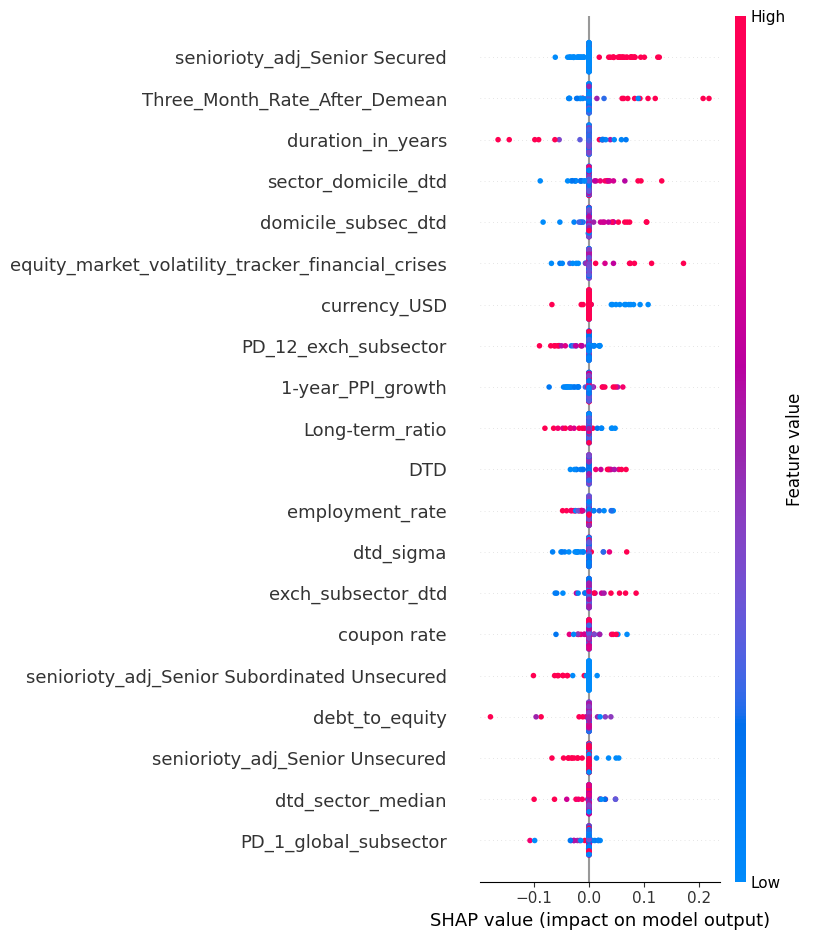

<Figure size 640x480 with 0 Axes>

In [34]:
# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, explain_data, feature_names=train_features.columns)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

5-fold CV

In [35]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,False,False,False,False,False,False,False,False,False,False
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,False,True,False,False,False,False,False,False,False,False
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,False,False,False,False,False,False,False,False,False,False
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,False,False,False,False,False,False,False,False,False,False


In [36]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [11]:
model = SVR(**best_params)
pipeline = Pipeline([
    ('preprocessor', scaler),
    ('svr', model)
])
pipeline.fit(train_features, train_labels)

/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['coupon rate', 'SP500 MD',
                                                   'Average daily 1-year SP500 '
                                                   'return',
                                                   'Ratio to MA',
                                                   'US Corporate Bond Yield '
                                                   'Spread',
                                                   'US Corporate Bond Yield '
                                                   'Spread(3-5 year)',
                                                   'US Corporate Bond Yield '
                                                   'Spread(5-7 year)',
                                                   'US Corporate Bond Yield '
                                                   'Spread(7-10 year)',
                                                   'US Corporate Bond...
                                                   'US Generic Govt 10 Year '
                                                   'Yield',
                                                   'marketcap',
                                                   'sector_domicile_dtd',
                                                   'sector_exchange_dtd',
                                                   'sector_dtd',
                                                   'PD_1_domicile_sector',
                                                   'PD_3_domicile_sector',
                                                   'PD_12_domicile_sector',
                                                   'PD_1_domicile_subsec',
                                                   'PD_3_domicile_subsec',
                                                   'PD_12_domicile_subsec',
                                                   'PD_1_exch_sector',
                                                   'PD_3_exch_sector',
                                                   'PD_12_exch_sector', ...])])),
                ('svr',
                 SVR(C=30.942911822250487, epsilon=0.19641631915251315))])

In [ ]:
# import os
# import pickle

# import numpy as np
# from sklearn.model_selection import KFold
# from tqdm import tqdm


# def run_kfold_eval(
# 	features: np.ndarray, 
#   labels: np.ndarray, 
#   n_folds: int, 
#   model: object, 
#   model_params: dict | None,
#   output_path: str,
#   name: str='rf_model', 
#   seed=42
# ):  
#     kf = KFold(n_splits=n_folds)
#     if seed:
#         kf = KFold(
#             n_splits=n_folds, 
#             shuffle=True,
#             random_state=seed
#         )
#     oof_preds = []
#     train_preds = []
#     test_preds = []

#     train_metrics = {}
#     val_metrics = {}

#     feat_importances = np.zeros(features.shape[1])

#     bar = tqdm(total=n_folds)
#     for fold, (train_idx, val_idx) in enumerate(kf.split(features)):

#         if model_params != None:
#             x_train, x_val = features[train_idx], features[val_idx]
#             y_train, y_val = labels[train_idx], labels[val_idx]
#             reg = model(**model_params)
#         else:
#             x_train, x_val = features.iloc[train_idx], features.iloc[val_idx]
#             y_train, y_val = labels[train_idx], labels[val_idx]
#             reg = model
#         reg.fit(x_train, y_train)
        
#         # Prediction on train data
#         preds = reg.predict(x_train)
#         train_preds.append(preds)

#         # save metrics
#         mae, mape, rmse, rsqr = calculate_metric(preds, y_train)
#         train_metrics[f"mae_fold{fold}"] = mae
#         train_metrics[f"mape_fold{fold}"] = mape
#         train_metrics[f"rmse_fold{fold}"] = rmse
#         train_metrics[f"rsqr_fold{fold}"] = rsqr
        
#         # Prediction on val data
#         preds = reg.predict(x_val)
#         oof_preds.append(preds)

#         # save metrics
#         mae, mape, rmse, rsqr = calculate_metric(preds, y_val)
#         val_metrics[f"mae_fold{fold}"] = mae
#         val_metrics[f"mape_fold{fold}"] = mape
#         val_metrics[f"rmse_fold{fold}"] = rmse
#         val_metrics[f"rsqr_fold{fold}"] = rsqr

#         # Feature importance
#         if hasattr(reg, 'feature_importances_'):
#             feat_importances += reg.feature_importances_
#         elif hasattr(reg, 'coef_'):
#             feat_importances += reg.coef_

#         pickle.dump(
#             reg, 
#             open(os.path.join(output_path, f"{name}_{seed}_fold-{fold + 1}.pkl"), "wb")
#         )
#         bar.update()
        
#     feat_importances /= n_folds

#     return train_preds, oof_preds, feat_importances, train_metrics, val_metrics

In [39]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(features, labels.to_numpy(), n_folds=5, model=pipeline, model_params=None, output_path=OUTPUT_PATH, name="svm")

  0%|          | 0/5 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|██        | 1/5 [00:00<00:02,  1.70it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 40%|████      | 2/5 [00:01<00:01,  1.68it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

In [40]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3366597096244105
Test average mean absolute percentage error: 3711.5040165325436
Test average root mean squared error: 0.23550230084634852
Test average R2: 0.49346370613579615


SAVING OUT-OF-FOLD PREDICTIONS 

In [14]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(train_features, train_labels.to_numpy(), n_folds=5, model=pipeline, model_params=None, output_path=OUTPUT_PATH, name="svm", saving_model=False)

  0%|          | 0/5 [00:00<?, ?it/s]/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|██        | 1/5 [00:00<00:00,  5.15it/s]/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 40%|████      | 2/5 [00:00<00:00,  4.97it/s]/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 60

In [15]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3339259503896827
Test average mean absolute percentage error: 4942.310114348894
Test average root mean squared error: 0.25023798429426725
Test average R2: 0.4149238652818357


In [17]:
oof_predictions_df = pd.DataFrame({"predictions": oof_preds.ravel()})
with pd.ExcelWriter(OOF_PREDICTIONS_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    oof_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)